## Setup

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import itertools

import numpy as np
import jsonpickle
import pandas as pd
from tqdm import trange

from environment import Car, TrafficModel
from util.network import create_braess_network, create_random_grid_network, OneXLatencyGenerator, update_latency_functions
from util.analysis import plot_toll_per_edge, plot_cars_per_route, plot_latency_increase_per_edge, draw_latency_params, draw_network
from governance import sort_edges_by_latency_increase

## Generate and store random grid model

In [109]:
network = create_random_grid_network(3, 4, latency_generator=OneXLatencyGenerator(), p=1.0)
cars = {i: Car(i, (0, 0), (1, 2)) for i in range(20)}

model = TrafficModel(network, cars)

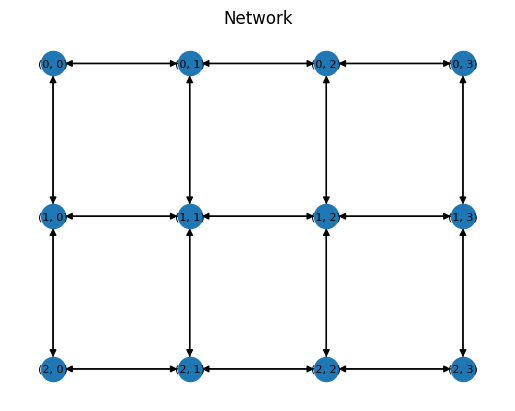

In [110]:
draw_network(model)

In [111]:
model.dump('grid.json')

## Load and execute model

In [42]:
model = TrafficModel.load('test2.json')

In [43]:
model.verbose = True

step_stats, car_stats = model.run_sequentially(20)

Step 0:
Positions before step 0: [(((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0)]
Positions after step 0: [(((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)), 1.0), (((0, 0), (0, 0)

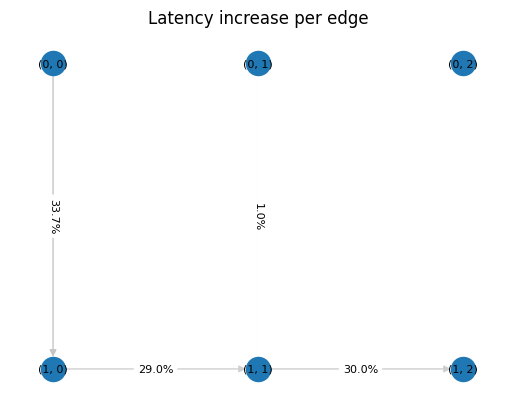

In [44]:
plot_latency_increase_per_edge(model, step_stats)

In [45]:
(-car_stats["travel_time"]).mean()

-6.0

In [ ]:
number_of_steps = 100

network = create_braess_network(capacity=2)
cars = {
    0: Car(0, 0, 3, 1, anticipation_strategy='edge_tolls', position=((0, 1), 0), value_of_time=1, verbose=False),
    1: Car(1, 0, 3, 1, anticipation_strategy='edge_tolls', position=((0, 1), 0), value_of_time=1, verbose=False)
}

model = TrafficModel(network, cars)

step_stats, car_stats = model.run_sequentially(number_of_steps)

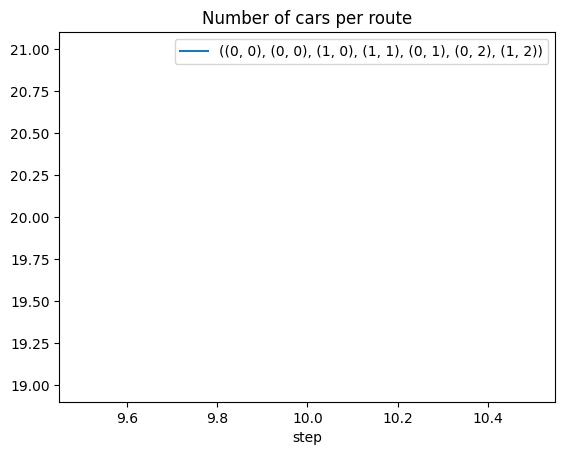

In [8]:
plot_cars_per_route(car_stats)

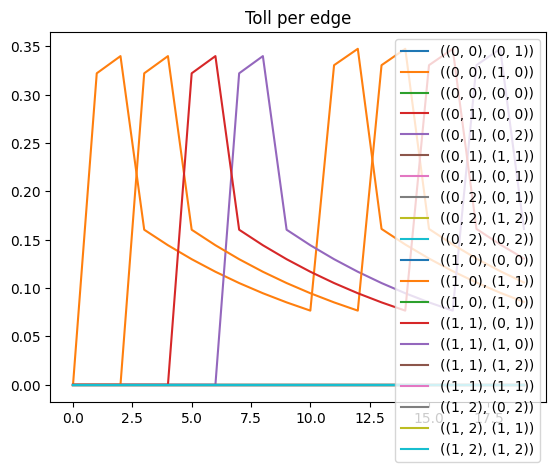

In [9]:
plot_toll_per_edge(step_stats)

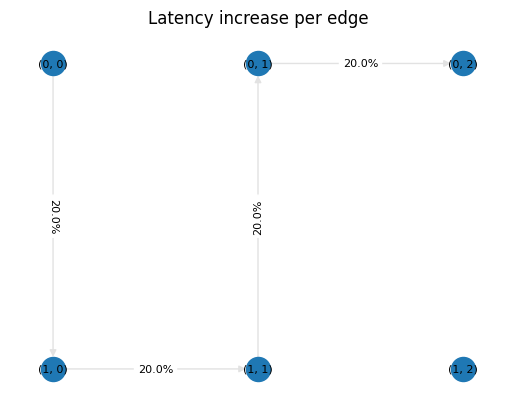

In [10]:
plot_latency_increase_per_edge(model, step_stats)

## Close edges individually and compare social welfare

In [97]:
def change_capacity(network, capacity):
    for edge in network.edges:
        a, b, _ , d = network.edges[edge]['latency_params']
        network.edges[edge]['latency_params'] = (a, b, capacity, d)

    update_latency_functions(network)

In [100]:
def find_optimal_capacity(model_file, number_of_steps=100, number_of_edges_to_remove=2):
    results = []
    for capacity in trange(1, 30):
        # Run baseline model (no edges closed)
        base_model = TrafficModel.load(model_file)
        change_capacity(base_model.network, capacity)
        step_stats, car_stats = base_model.run_sequentially(number_of_steps, show_progress=False)

        if len(car_stats) > 0:
            base_social_welfare = (-car_stats["travel_time"]).mean()
        else:
            raise ValueError('Invalid network!')

        # Close edges and run model
        result = []
        for edges in itertools.combinations(base_model.network.edges, number_of_edges_to_remove):
            model = TrafficModel.load(model_file)
            change_capacity(model.network, capacity)
            
            for edge in edges:
                model.set_edge_restriction(edge, False)

            step_stats, car_stats = model.run_sequentially(number_of_steps, show_progress=False)

            if len(car_stats) > 0:
                result.append({'closed_edges': edges, 'result': (-car_stats["travel_time"]).mean()})


        # Find best/worst restriction
        result = pd.DataFrame(result)
        results.append({'capacity': capacity, 'max': result['result'].max(), 'min': result['result'].min()})

    # Return optimal capacity with optimal restriction and improvement
    return pd.DataFrame(results)

In [112]:
results = find_optimal_capacity('grid.json', number_of_edges_to_remove=1)

100%|██████████| 29/29 [04:40<00:00,  9.67s/it]


<Axes: >

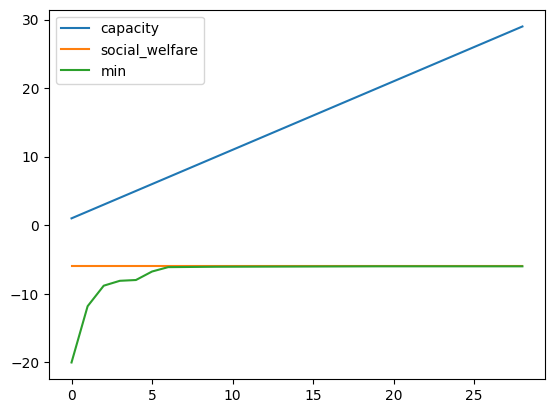

In [113]:
results.plot()

## Total cost analysis

In [25]:
number_of_steps = 100

network = create_braess_network()
cars = {
    0: Car( 0, 0, 3, 1, anticipation_strategy='edge_tolls', position=((0, 0), 1), verbose=False),
    1: Car( 1, 0, 3, 1, anticipation_strategy='edge_tolls', position=((0, 0), 1), verbose=False),
    # 2: Car( 2, 0, 3, 1, anticipation_strategy='edge', position=((1, 2), 0), verbose=True)
}

model = TrafficModel(network, cars, tolls=True, beta=1, R=1)

step_stats, car_stats = model.run_sequentially(number_of_steps)

100%|██████████| 100/100 [00:00<00:00, 5725.70it/s]


In [26]:
step_stats

route                 flow                                     \
               0             1 (0, 1) (0, 2) (0, 0) (1, 2) (1, 3) (1, 1)   
0             []            []      0      0      2      0      0      0   
1   [0, 1, 2, 3]  [0, 1, 2, 3]      2      0      0      0      0      0   
2   [0, 1, 2, 3]  [0, 1, 2, 3]      2      0      0      0      0      0   
3   [0, 1, 2, 3]  [0, 1, 2, 3]      2      0      0      0      0      0   
4      [1, 2, 3]     [1, 2, 3]      0      0      0      2      0      0   
..           ...           ...    ...    ...    ...    ...    ...    ...   
95     [1, 2, 3]     [1, 2, 3]      0      0      0      2      0      0   
96        [2, 3]        [2, 3]      0      0      0      0      0      0   
97        [2, 3]        [2, 3]      0      0      0      0      0      0   
98        [2, 3]        [2, 3]      0      0      0      0      0      0   
99  [0, 1, 2, 3]  [0, 1, 2, 3]      2      0      0      0      0      0   

                  ... latency   toll                                     \
   (2, 3) (2, 2)  ...  (3, 3) (0, 1) (0, 2) (0, 0) (1, 2) (1, 3) (1, 1)   
0       0      0  ...     1.0   0.00    0.0    0.0    0.0    0.0    0.0   
1       0      0  ...     1.0   0.12    0.0    0.0    0.0    0.0    0.0   
2       0      0  ...     1.0   0.12    0.0    0.0    0.0    0.0    0.0   
3       0      0  ...     1.0   0.12    0.0    0.0    0.0    0.0    0.0   
4       0      0  ...     1.0   0.00    0.0    0.0    0.0    0.0    0.0   
..    ...    ...  ...     ...    ...    ...    ...    ...    ...    ...   
95      0      0  ...     1.0   0.00    0.0    0.0    0.0    0.0    0.0   
96      2      0  ...     1.0   0.00    0.0    0.0    0.0    0.0    0.0   
97      2      0  ...     1.0   0.00    0.0    0.0    0.0    0.0    0.0   
98      2      0  ...     1.0   0.00    0.0    0.0    0.0    0.0    0.0   
99      0      0  ...     1.0   0.12    0.0    0.0    0.0    0.0    0.0   

                         
   (2, 3) (2, 2) (3, 3)  
0    0.00    0.0    0.0  
1    0.00    0.0    0.0  
2    0.00    0.0    0.0  
3    0.00    0.0    0.0  
4    0.00    0.0    0.0  
..    ...    ...    ...  
95   0.00    0.0    0.0  
96   0.12    0.0    0.0  
97   0.12    0.0    0.0  
98   0.12    0.0    0.0  
99   0.00    0.0    0.0  

[100 rows x 29 columns]

In [27]:
car_stats

,step,car_id,source,target,route,travel_time,toll
0,7,0,0,3,"(0, 0, 1, 2, 3)",7,0.12
1,7,1,0,3,"(0, 0, 1, 2, 3)",7,0.24
2,14,0,0,3,"(0, 1, 2, 3)",7,0.24
3,14,1,0,3,"(0, 1, 2, 3)",7,0.12
4,21,0,0,3,"(0, 1, 2, 3)",7,0.12
5,21,1,0,3,"(0, 1, 2, 3)",7,0.24
6,28,0,0,3,"(0, 1, 2, 3)",7,0.18
7,28,1,0,3,"(0, 1, 2, 3)",7,0.18
8,35,0,0,3,"(0, 1, 2, 3)",7,0.12
9,35,1,0,3,"(0, 1, 2, 3)",7,0.24


In [30]:
-car_stats.apply(lambda row: row['travel_time'] * model.cars[row['car_id']].value_of_time + row['toll'] * model.cars[row['car_id']].value_of_money, axis=1)

0    -7.12
1    -7.24
2    -7.24
3    -7.12
4    -7.12
5    -7.24
6    -7.18
7    -7.18
8    -7.12
9    -7.24
10   -7.12
11   -7.24
12   -7.24
13   -7.12
14   -7.12
15   -7.24
16   -7.12
17   -7.24
18   -7.18
19   -7.18
20   -7.18
21   -7.18
22   -7.18
23   -7.18
24   -7.12
25   -7.24
26   -7.12
27   -7.24
dtype: float64

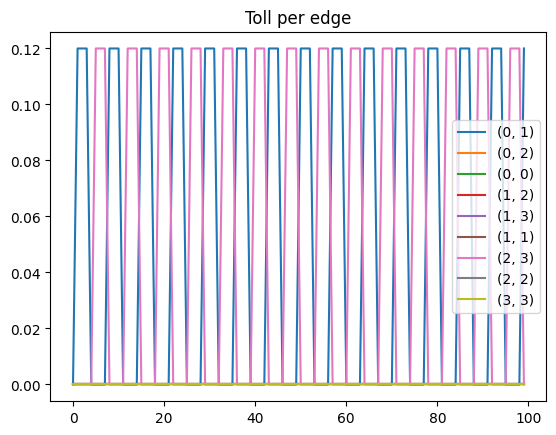

In [29]:
plot_toll_per_edge(step_stats)

# Playground

In [88]:
from util.network import create_random_gnp_graph, OneXLatencyGenerator

create_random_gnp_graph(10, 0.5, OneXLatencyGenerator()).edges

OutEdgeView([(0, 2), (0, 3), (0, 4), (0, 8), (0, 9), (0, 0), (1, 0), (1, 2), (1, 4), (1, 5), (1, 8), (1, 1), (2, 1), (2, 5), (2, 6), (2, 8), (2, 9), (2, 2), (3, 0), (3, 8), (3, 3), (4, 6), (4, 7), (4, 8), (4, 9), (4, 4), (5, 0), (5, 1), (5, 2), (5, 4), (5, 6), (5, 7), (5, 8), (5, 5), (6, 2), (6, 4), (6, 5), (6, 6), (7, 3), (7, 4), (7, 5), (7, 6), (7, 8), (7, 7), (8, 1), (8, 3), (8, 5), (8, 6), (8, 7), (8, 8), (9, 0), (9, 3), (9, 4), (9, 7), (9, 8), (9, 9)])